In [1]:
import os
import zipfile
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow import keras

In [2]:
! pip install -q kaggle
from google.colab import files

files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"samuelnababan","key":"253028c1582d27528dd63dc51a5b9125"}'}

In [3]:
!mkdir ~/.kaggle

In [4]:
!cp kaggle.json ~/.kaggle/

In [5]:
!chmod 600 ~/.kaggle/kaggle.json

In [6]:
!kaggle datasets download -d muttaqin1113/face-skin-type

Dataset URL: https://www.kaggle.com/datasets/muttaqin1113/face-skin-type
License(s): apache-2.0
100% 56.0M/56.0M [00:03<00:00, 19.0MB/s]
100% 56.0M/56.0M [00:03<00:00, 15.0MB/s]


In [7]:
!unzip -q /content/face-skin-type.zip \
  && rm /content/face-skin-type.zip

In [8]:
!pip install split-folders

In [10]:
import splitfolders
input_folder='/content/skin2'

splitfolders.ratio(input_folder, output="Skin Type",
                   seed=42, ratio=(.7,.2,.1),
                  group_prefix=None)

Copying files: 1735 files [00:00, 4129.01 files/s]


In [11]:
def train_val_generators(TRAINING_DIR, VALIDATION_DIR):
  train_datagen = ImageDataGenerator(rescale = 1./255,
                                   rotation_range = 45,
                                   width_shift_range = 0.25,
                                   height_shift_range = 0.25,
                                   shear_range = 0.25,
                                   zoom_range = 0.5,
                                   fill_mode = 'nearest',
                                   horizontal_flip = True)

  train_generator = train_datagen.flow_from_directory(directory=TRAINING_DIR,
                                                      batch_size=32,
                                                      class_mode='categorical',
                                                      target_size=(224, 224),
                                                      shuffle = True)

  validation_datagen = ImageDataGenerator(rescale = 1./255)

  validation_generator = validation_datagen.flow_from_directory(directory=VALIDATION_DIR,
                                                                batch_size=32,
                                                                class_mode='categorical',
                                                                target_size=(224, 224),
                                                                shuffle=False)

  return train_generator, validation_generator

In [13]:
TRAINING_DIR = '/content/Skin Type/train'
VALIDATION_DIR = '/content/Skin Type/val'

In [14]:
train_generator, validation_generator = train_val_generators(TRAINING_DIR, VALIDATION_DIR)

Found 1211 images belonging to 4 classes.
Found 346 images belonging to 4 classes.


In [15]:
from tensorflow.keras.preprocessing import image_dataset_from_directory
train_dataset = image_dataset_from_directory(TRAINING_DIR,
                                             shuffle=True,
                                             image_size=(224,224))

Found 1211 files belonging to 4 classes.


In [16]:
class_names = train_dataset.class_names
print(class_names)

['berjerawat', 'berminyak', 'kering', 'normal']


In [21]:
model = tf.keras.models.Sequential([
    # First convolutional block
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2)),

    # Second convolutional block
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2)),

    # Third convolutional block
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2)),

    # Fourth convolutional block
    tf.keras.layers.Conv2D(256, (3, 3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2)),

    # Fifth convolutional block
    tf.keras.layers.Conv2D(512, (3, 3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2)),

    # Sixth convolutional block
    tf.keras.layers.Conv2D(1024, (3, 3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2)),

    # Global Average Pooling layer
    tf.keras.layers.GlobalAveragePooling2D(),

    # Fully connected dense layer
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.6),

    # Output layer
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(4, activation='softmax')
])

model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)                    │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 222, 222, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 109, 109, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 52, 52, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_8                │ (None, 52, 52, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 24, 24, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_9                │ (None, 24, 24, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 12, 12, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 10, 10, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_10               │ (None, 10, 10, 512)         │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 5, 5, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 3, 3, 1024)          │       4,719,616 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_11               │ (None, 3, 3, 1024)          │           4,096 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 1, 1, 1024)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 6,953,412 (26.53 MB)

 Trainable params: 6,949,380 (26.51 MB)

 Non-trainable params: 4,032 (15.75 KB)

In [22]:
learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [23]:
history = model.fit(train_generator,
                    epochs=100,
                    validation_data=validation_generator,
                    verbose = 2)

Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


38/38 - 56s - 1s/step - accuracy: 0.3369 - loss: 1.9152 - val_accuracy: 0.2486 - val_loss: 1.4115
Epoch 2/100
38/38 - 49s - 1s/step - accuracy: 0.3947 - loss: 1.5439 - val_accuracy: 0.2486 - val_loss: 1.5985
Epoch 3/100
38/38 - 18s - 464ms/step - accuracy: 0.4393 - loss: 1.4366 - val_accuracy: 0.2486 - val_loss: 1.6561
Epoch 4/100
38/38 - 21s - 564ms/step - accuracy: 0.4443 - loss: 1.3433 - val_accuracy: 0.2428 - val_loss: 1.9441
Epoch 5/100
38/38 - 18s - 465ms/step - accuracy: 0.4641 - loss: 1.3190 - val_accuracy: 0.2486 - val_loss: 1.8311
Epoch 6/100
38/38 - 22s - 572ms/step - accuracy: 0.4715 - loss: 1.2767 - val_accuracy: 0.2023 - val_loss: 1.7291
Epoch 7/100
38/38 - 17s - 459ms/step - accuracy: 0.4616 - loss: 1.2603 - val_accuracy: 0.2197 - val_loss: 1.5966
Epoch 8/100
38/38 - 18s - 475ms/step - accuracy: 0.4938 - loss: 1.2138 - val_accuracy: 0.2399 - val_loss: 1.6977
Epoch 9/100
38/38 - 20s - 525ms/step - accuracy: 0.4955 - loss: 1.1915 - val_accuracy: 0.3121 - val_loss: 1.3980
E

In [24]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

--2024-11-23 13:05:13--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 172.253.118.207, 74.125.200.207, 74.125.130.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.253.118.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M  23.6MB/s    in 4.7s    

2024-11-23 13:05:18 (17.9 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]



In [25]:
# Import the inception model
from tensorflow.keras.applications.inception_v3 import InceptionV3

# Create an instance of the inception model from the local pre-trained weights
local_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

In [26]:
def create_pre_trained_model(local_weights_file):

  pre_trained_model = InceptionV3(weights='imagenet',
                              include_top=False,
                              input_shape=(224,224, 3))

  #pre_trained_model.load_weights(local_weights_file)

  # Make all the layers in the pre-trained model non-trainable
  for layers in pre_trained_model.layers:
    layers.trainable = False



  return pre_trained_model

In [27]:
pre_trained_model = create_pre_trained_model(local_weights_file)

# Print the model summary
pre_trained_model.summary()

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


Model: "inception_v3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_12 (Conv2D)        │ (None, 111, 111, 32)   │            864 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_12    │ (None, 111, 111, 32)   │             96 │ conv2d_12[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 111, 111, 32)   │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_13 (Conv2D)        │ (None, 109, 109, 32)   │          9,216 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_13    │ (None, 109, 109, 32)   │             96 │ conv2d_13[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 109, 109, 32)   │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_14 (Conv2D)        │ (None, 109, 109, 64)   │         18,432 │ activation_1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_14    │ (None, 109, 109, 64)   │            192 │ conv2d_14[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 109, 109, 64)   │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_12          │ (None, 54, 54, 64)     │              0 │ activation_2[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_15 (Conv2D)        │ (None, 54, 54, 80)     │          5,120 │ max_pooling2d_12[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_15    │ (None, 54, 54, 80)     │            240 │ conv2d_15[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_3 (Activation) │ (None, 54, 54, 80)     │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_16 (Conv2D)        │ (None, 52, 52, 192)    │        138,240 │ activation_3[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_16    │ (None, 52, 52, 192)    │            576 │ conv2d_16[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├──────────────────────

 Total params: 21,802,784 (83.17 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 21,802,784 (83.17 MB)

In [28]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>=0.95 and logs.get('val_accuracy')>=0.95):
      print("\nReached 95.9% accuracy so cancelling training!")
      self.model.stop_training = True

In [31]:
def output_of_last_layer(pre_trained_model):

  last_desired_layer = pre_trained_model.get_layer('mixed4')
  print('last layer output shape: ', last_desired_layer.output.shape)
  last_output = last_desired_layer.output
  print('last layer output: ', last_output)


  return last_output

In [32]:
last_output = output_of_last_layer(pre_trained_model)

last layer output shape:  (None, 12, 12, 768)
last layer output:  <KerasTensor shape=(None, 12, 12, 768), dtype=float32, sparse=False, name=keras_tensor_180>


In [33]:
print(f"The pretrained model has type: {type(pre_trained_model)}")

The pretrained model has type: <class 'keras.src.models.functional.Functional'>


In [37]:
x = keras.layers.GlobalAveragePooling2D()(last_output)
x = keras.layers.Dense (256, activation='relu')(x)
x = keras.layers.Dropout(0.5)(x)
x = keras.layers.Dense (4, activation='softmax')(x)
model2 = Model(pre_trained_model.input, x)
model2.summary()

model2.compile(optimizer=keras.optimizers.Adam(0.0001),  # Low learning rate
                loss='categorical_crossentropy',
                metrics=['accuracy'])

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_12 (Conv2D)        │ (None, 111, 111, 32)   │            864 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_12    │ (None, 111, 111, 32)   │             96 │ conv2d_12[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 111, 111, 32)   │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_13 (Conv2D)        │ (None, 109, 109, 32)   │          9,216 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_13    │ (None, 109, 109, 32)   │             96 │ conv2d_13[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 109, 109, 32)   │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_14 (Conv2D)        │ (None, 109, 109, 64)   │         18,432 │ activation_1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_14    │ (None, 109, 109, 64)   │            192 │ conv2d_14[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 109, 109, 64)   │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_12          │ (None, 54, 54, 64)     │              0 │ activation_2[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_15 (Conv2D)        │ (None, 54, 54, 80)     │          5,120 │ max_pooling2d_12[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_15    │ (None, 54, 54, 80)     │            240 │ conv2d_15[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_3 (Activation) │ (None, 54, 54, 80)     │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_16 (Conv2D)        │ (None, 52, 52, 192)    │        138,240 │ activation_3[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_16    │ (None, 52, 52, 192)    │            576 │ conv2d_16[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├──────────────────────

 Total params: 3,643,812 (13.90 MB)

 Trainable params: 197,892 (773.02 KB)

 Non-trainable params: 3,445,920 (13.15 MB)

In [38]:
callbacks = myCallback()
history = model2.fit(train_generator,
                    validation_data = validation_generator,
                    epochs = 100,
                    verbose = 2,
                    callbacks = [callbacks]
                    )

Epoch 1/100
38/38 - 41s - 1s/step - accuracy: 0.2659 - loss: 1.4317 - val_accuracy: 0.4046 - val_loss: 1.3318
Epoch 2/100
38/38 - 22s - 592ms/step - accuracy: 0.3295 - loss: 1.3725 - val_accuracy: 0.5087 - val_loss: 1.2677
Epoch 3/100
38/38 - 19s - 487ms/step - accuracy: 0.3964 - loss: 1.3096 - val_accuracy: 0.6127 - val_loss: 1.2185
Epoch 4/100
38/38 - 22s - 572ms/step - accuracy: 0.4484 - loss: 1.2722 - val_accuracy: 0.6474 - val_loss: 1.1703
Epoch 5/100
38/38 - 19s - 490ms/step - accuracy: 0.4831 - loss: 1.2232 - val_accuracy: 0.6590 - val_loss: 1.1171
Epoch 6/100
38/38 - 20s - 518ms/step - accuracy: 0.5326 - loss: 1.1756 - val_accuracy: 0.6792 - val_loss: 1.0714
Epoch 7/100
38/38 - 17s - 438ms/step - accuracy: 0.5260 - loss: 1.1674 - val_accuracy: 0.7023 - val_loss: 1.0259
Epoch 8/100
38/38 - 17s - 446ms/step - accuracy: 0.5772 - loss: 1.1141 - val_accuracy: 0.6908 - val_loss: 0.9951
Epoch 9/100
38/38 - 20s - 538ms/step - accuracy: 0.5945 - loss: 1.0861 - val_accuracy: 0.7254 - val

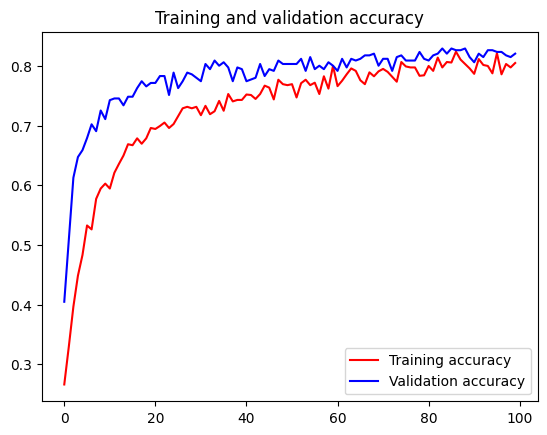

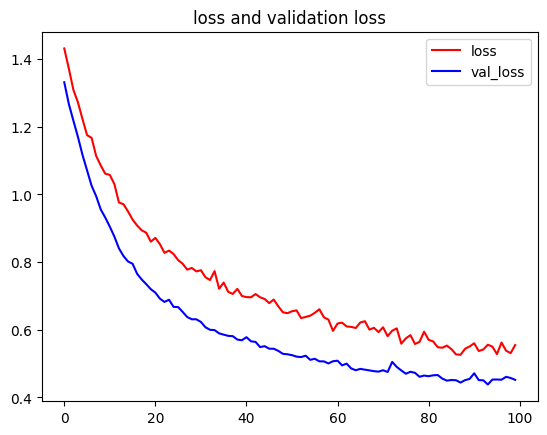

<Figure size 640x480 with 0 Axes>

In [39]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.plot(epochs, loss, 'r', label='loss')
plt.plot(epochs, val_loss, 'b', label='val_loss')
plt.title('loss and validation loss')
plt.legend(loc=0)
plt.figure()
plt.show()


In [40]:
from tensorflow import keras
pre_trained_model.trainable = True
#model2.summary()

model2.compile(
    optimizer=keras.optimizers.Adam(1e-5),  # Low learning rate
                loss = keras.losses.CategoricalCrossentropy(from_logits=True),
                metrics = ['accuracy']
)


model2.fit(train_generator,
           validation_data=validation_generator,
           epochs = 50)

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/nn.py:593: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


38/38 ━━━━━━━━━━━━━━━━━━━━ 33s 614ms/step - accuracy: 0.8018 - loss: 0.5532 - val_accuracy: 0.8295 - val_loss: 0.4407
Epoch 2/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 18s 394ms/step - accuracy: 0.7947 - loss: 0.5540 - val_accuracy: 0.8324 - val_loss: 0.4400
Epoch 3/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 19s 414ms/step - accuracy: 0.8184 - loss: 0.5075 - val_accuracy: 0.8324 - val_loss: 0.4405
Epoch 4/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 18s 394ms/step - accuracy: 0.8080 - loss: 0.5334 - val_accuracy: 0.8353 - val_loss: 0.4385
Epoch 5/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 18s 398ms/step - accuracy: 0.8347 - loss: 0.4966 - val_accuracy: 0.8324 - val_loss: 0.4383
Epoch 6/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 20s 397ms/step - accuracy: 0.8072 - loss: 0.5210 - val_accuracy: 0.8353 - val_loss: 0.4365
Epoch 7/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 18s 400ms/step - accuracy: 0.8398 - loss: 0.4834 - val_accuracy: 0.8324 - val_loss: 0.4370
Epoch 8/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 19s 395ms/step - accuracy: 0.8314 - loss: 0.5086 - val_accuracy: 0.835

Saving 14.jpg to 14.jpg
Saving 13.jpg to 13.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


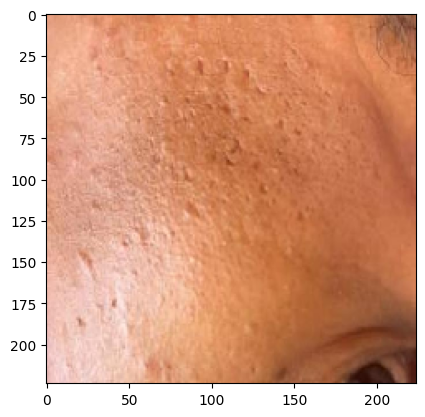

berjerawat: 18.91%
berminyak: 58.84%
kering: 12.01%
normal: 10.24%

Result:
berminyak: 58.84%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


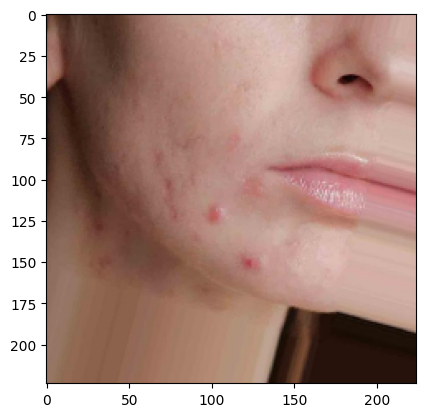

berjerawat: 94.78%
berminyak: 0.28%
kering: 4.74%
normal: 0.20%

Result:
berjerawat: 94.78%


In [41]:
import numpy as np
from google.colab import files
from keras.preprocessing import image
from tensorflow.keras.applications.inception_v3 import preprocess_input

labels = train_generator.class_indices.keys()
uploaded = files.upload()

for paths in uploaded.keys():
    path = paths
    img = image.load_img(path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)

    images = np.vstack([x])
    proba = model2.predict(images)[0]
    maxx = proba.max()
    plt.imshow(img)
    plt.show()

    for (label, p) in zip(labels, proba):
        print("{}: {:.2f}%".format(label, p * 100))

    max_index = np.argmax(proba)
    max_proba = proba[max_index]
    max_label = list(labels)[max_index]

    if max_proba >= 0.5:
        print('\nResult:')
        print("{}: {:.2f}%".format(max_label, max_proba * 100))
    else:
        print('\nResult:')
        print('Hasil tidak ditemukan!')

In [42]:
#Save the model in TensorFlow format
model2.save("my_model.h5")

In [43]:
import tensorflow as tf

# Load the TensorFlow model
model = tf.keras.models.load_model('/content/my_model.h5')

# Convert the model
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the converted model to a .tflite file
with open('converted_model.tflite', 'wb') as f:
    f.write(tflite_model)

Saved artifact at '/tmp/tmpzo9_l4tk'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_layer_2')
Output Type:
  TensorSpec(shape=(None, 4), dtype=tf.float32, name=None)
Captures:
  133302384217952: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133302384227280: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133302384229392: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133302384224992: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133302384228864: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133302384232928: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133302384231168: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133302384231344: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133302384236800: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133302384236448: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1333023842360